# Enhancer proximity for DEGs in 24h dNipBL

***Purpose:*** Investigating whether enhancer proximity, as measured by distance between gene to closest enhancer or concentration of enhancers within the same TAD, are predictive of gene dysregulation in 1 day of dNipBL-depleted mESCs. 

**Process:** Plotting across the following variables:
* Portion of dysregulated genes sorted by distance to closest enhancer
* Number of enhancers within the same TAD compared to number of dysregulated genes in the same TAD

In [153]:
import plotting_heatmap_functions as pfn
import filter_gene_functions as flt

In [154]:
# ignore FutureWarnings generated by pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import bioframe as bf
from gtfparse import read_gtf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [155]:
proj = "/project/fudenber_735/collaborations/karissa_2022/20220812_EA18-1_RNAseq-Analysis_forGeoff/"
# Importing day 1 depletion in ESCs DEGS
day1_sigRes = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_resSig_ESC_1d-depletion.csv'

normalized_counts = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_ESC-1d_sf-normalized.csv'
feature_counts = '20220816_featureCounts.csv'
WT_samples = ['KHRNA1', 'KHRNA7', 'KHRNA13', 'KHRNA22', 'KHRNA23', 'KHRNA50']

# import results table
day1_res_df = pd.read_csv(proj+day1_sigRes)

# add feature counts information to label genes not in the significant results table
feat_counts_df = pd.read_csv(proj+feature_counts)
day1_res_df = day1_res_df.merge(feat_counts_df['Geneid'], how='outer')

### Add feature annotations to gene set: TSS locations, DE status label, distance to closest enhancer

In [156]:
# Getting TSSEs
tss_df = read_gtf("/project/fudenber_735/collaborations/karissa_2022/old/RNAseq/STAR_Gencode_alignment/tss_annotions_gencode.vM23.primary_assembly.gtf")
ts_intervals = flt.get_tss_gene_intervals(tss_df)

# labelling our dataset
day1_res_df = day1_res_df.merge(ts_intervals, left_on='Geneid', right_on='gene_id', how='left')

# Checking if any of the significant genes will be lost due to loss of TSS annotation
print("Checking for 'lost' significant genes: ")
ix = np.where(day1_res_df['start'].isna() & (day1_res_df['padj'] < 0.05))
print("lost: ", str(day1_res_df.iloc[ix].shape[0]))
# If could not find a TSS, drop entire row
day1_res_df.dropna(subset=['start'], inplace=True)

# Remove any genes mapped to chrX before proceeding --> save these for later analysis
day1_res_df = day1_res_df[~day1_res_df.chrom.isin(['chrX'])]
day1_res_df = bf.sanitize_bedframe(day1_res_df)

# Add the differential expression status for filtering genes
day1_res_df = flt.label_DE_status(day1_res_df)

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'level', 'transcript_support_level', 'mgi_id', 'tag', 'havana_gene', 'havana_transcript', 'protein_id', 'ccdsid', 'ont']


Checking for 'lost' significant genes: 
lost:  0


### import enhancer files

In [157]:
dataset_folder = '/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/Published_datasets/'

chen_s1 = 'Enhancers_Chen2012_S1_remapped_mm10.bed'
whythe_super = 'Super-enhancers_mESCs_(OSN-MED1)_Wythe-Cell-2023_mm10-lifetover.bed'
# whythe_reg = 'remapped_enhancers_Whyte_2013_mm9.bed.txt' <-- where is this?

enhancers = {'chen_s1' : dataset_folder+chen_s1,
             'wythe_super' : dataset_folder+whythe_super}

### label distance to closest enhancer for each gene

In [158]:
for label, file in enhancers.items():
    day1_res_df = flt.label_closest_enhancer(day1_res_df, file, label)

In [159]:
print('how many genes did not receive an enhancer label --> dropped')
print((day1_res_df['chen_s1_distance'].isna() |
       day1_res_df['wythe_super_distance'].isna()
      ).sum())
day1_res_df.dropna(subset=
                   ['chen_s1_distance', 
                    'wythe_super_distance'], 
                   inplace=True
                  )

how many genes did not receive an enhancer label --> dropped
55


# Plot cumulative distance

In [160]:
import importlib
importlib.reload(pfn)

<module 'plotting_heatmap_functions' from '/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/plotting_heatmap_functions.py'>

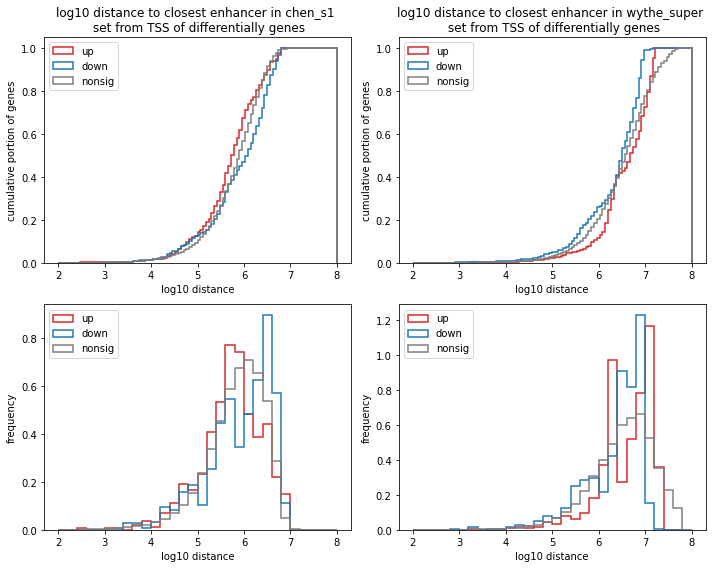

In [161]:
fig, axs = plt.subplots(2,2, figsize=(10, 8))

for (enhancer_label, file), axi in zip(enhancers.items(), np.arange(axs.shape[0])):
    pfn.plot_cumulative_distance(day1_res_df, 
                                 enhancer_label+'_distance', 
                                 ax=axs[0, axi],
                                 plot_title='log10 distance to closest enhancer in {} \n set from TSS of differentially genes'.format(enhancer_label))
    
    pfn.plot_distance_histogram(day1_res_df, 
                                enhancer_label+'_distance', 
                                ax=axs[1, axi],
                                bins=30)
    
plt.tight_layout()
plt.show()

# Enhancer concentration within TAD Boundaries

In [181]:
import cooler
#import cooltools

In [182]:
# load features for boundaries
feature_dir = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/features'
# load boundaries
insulation_table = pd.read_table(feature_dir+'/bonev2017.HiC_ES.mm10.mapq_30.1000.window_200000.insulation')
insulation_boundaries = insulation_table.query('is_boundary_200000 == True')

# Dropping any coordinates with chrX
num_chrx = len(insulation_boundaries[insulation_boundaries['chrom'] == 'chrX'])
insulation_boundaries = insulation_boundaries[~insulation_boundaries.chrom.isin(['chrX'])]
print('Dropped {} insulation boundary coordinates, that fell on Chrom X'.format(num_chrx))

#load cooler to get chrom sizes for this particular dataset
resolution = 10_000
cooler_file = '/'.join(feature_dir.split('/')[:-1])+'/HiC_ES.mm10.mapq_30.1000.mcool'
c = cooler.Cooler(cooler_file+'::resolutions/'+str(resolution))

Dropped 263 insulation boundary coordinates, that fell on Chrom X


### Process insulation boundaries to represent TADs as genomic intervals

In [183]:
# todo: move the following data processing into filter_genes_functions
tad_df = pd.DataFrame(columns=['chrom', 'start', 'end'])

for chrom in insulation_boundaries.chrom.unique():
    
    chrom_boundaries = insulation_boundaries[insulation_boundaries['chrom'] == chrom]
    size = len(chrom_boundaries)
    TAD_starts = np.empty([size+1])
    TAD_starts[0] = 0
    TAD_starts[1:] = chrom_boundaries['end']
    
    TAD_ends = np.empty([size+1])
    TAD_ends[-1] = c.chromsizes[chrom]
    TAD_ends[0:-1] = chrom_boundaries['start']
    
    tmp = pd.DataFrame({'chrom' : chrom,
                        'start' : TAD_starts,
                        'end' : TAD_ends}
                      )
    tad_df = tad_df.append(tmp, ignore_index=True)
    

In [184]:
tad_df = bf.sanitize_bedframe(tad_df)

In [175]:
#tad_df = bf.count_overlaps(tad_df, day1_res_df[day1_res_df['DE_status'] == 'down'])

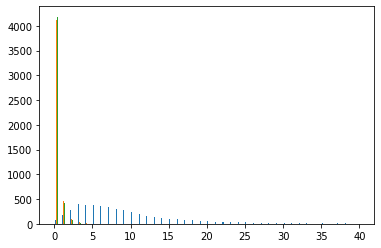

In [176]:
# plt.hist(tad_df['count'], range=(0,40), bins=80)
# plt.show()

In [ ]:
# The following is percent frequency

# todo: 
# [] adjust x-axis labeling so that its an integer
# [] add other labels
# [] re-factor into a function
# [] plot a few variations: frequency, raw counts

In [197]:
enhancers = bf.read_table(enhancers['chen_s1']).rename(
    columns={0: 'chrom',  1: 'start', 2: 'end'}
)

(array([3.918e+03, 5.300e+02, 1.740e+02, 6.300e+01, 1.900e+01, 7.000e+00,
        3.000e+00, 3.000e+00, 1.000e+00, 1.000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

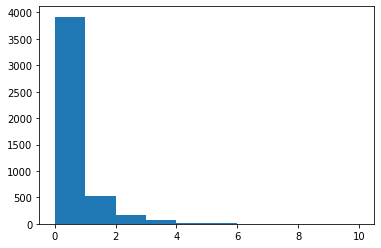

In [200]:
plt.hist(bf.count_overlaps(tad_df, enhancers)['count'])

In [201]:
tad_df['num_enhancers'] = bf.count_overlaps(tad_df, enhancers)['count']

<AxesSubplot:>

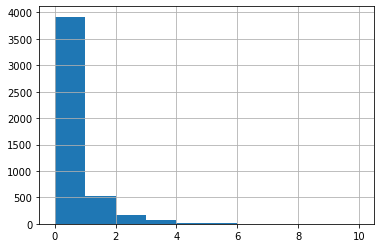

In [207]:
tad_df['num_enhancers'].hist()

In [193]:
cat_ix = np.where(df[agg_key] == 'up')


In [210]:
#bf.count_overlaps(tad_df, df.iloc[cat_ix])['count'].hist(by=['num_enhancers'])

In [ ]:
bf.count_overlaps(tad_df, 'chen_s1'

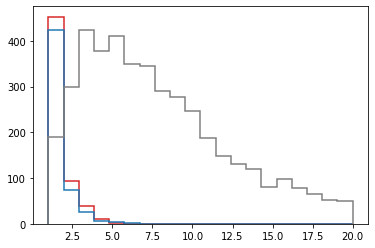

In [196]:
# This is plotting number of genes within each TAD window --> not yet categorized / labeled by number of enhancers within each TAD window
ax = plt.subplot()
agg_key='DE_status'
category_colors={"up": 'tab:red', 
                 "down": 'tab:blue', 
                 "nonsig": 'tab:gray'}
val_range=(1,20)
bins=20

df = day1_res_df.copy()
for cat, col in category_colors.items():

    cat_ix = np.where(df[agg_key] == cat)

    counts = bf.count_overlaps(tad_df, df.iloc[cat_ix])['count']

    ax.hist(counts,
            bins=bins,
            range=val_range,
            density=False,
            histtype='step',
            lw=1.5,
            label=cat, 
            color=col)

# if add_legend:
#     ax.legend(loc='upper left')
# ax.set(
#     xlabel='log10 distance',
#     ylabel='frequency'
# )
# if plot_title != None:
#     ax.set_title(plot_title)


In [84]:
insulation_boundaries[insulation_boundaries['chrom'] == 'chr3']

,chrom,start,end,region,is_bad_bin,log2_insulation_score_200000,n_valid_pixels_200000,boundary_strength_200000,is_boundary_200000
38091,chr3,3310000,3320000,chr3,True,-0.276488,270.0,0.837293,True
38132,chr3,3720000,3730000,chr3,True,-0.303079,324.0,0.622491,True
38222,chr3,4620000,4630000,chr3,True,-0.119214,324.0,0.308864,True
38280,chr3,5200000,5210000,chr3,False,-0.215001,377.0,0.283861,True
38390,chr3,6300000,6310000,chr3,True,-0.803473,361.0,1.240030,True
...,...,...,...,...,...,...,...,...,...
53513,chr3,157530000,157540000,chr3,False,-0.703128,358.0,0.999444,True
53546,chr3,157860000,157870000,chr3,False,-0.424875,377.0,0.617386,True
53570,chr3,158100000,158110000,chr3,False,-0.863095,397.0,1.424098,True
53676,chr3,159160000,159170000,chr3,True,-0.023275,304.0,0.355090,True


In [83]:
insulation_boundaries.head(5)

,chrom,start,end,region,is_bad_bin,log2_insulation_score_200000,n_valid_pixels_200000,boundary_strength_200000,is_boundary_200000
367,chr1,3670000,3680000,chr1,False,0.084095,397.0,0.390040,True
440,chr1,4400000,4410000,chr1,False,-0.425816,358.0,1.013374,True
477,chr1,4770000,4780000,chr1,False,-0.489156,397.0,1.002922,True
515,chr1,5150000,5160000,chr1,False,-0.231962,377.0,0.498138,True
590,chr1,5900000,5910000,chr1,False,-0.404405,397.0,0.873738,True


In [ ]:
# todo: to create TAD-windows --> cycle through insulation_boundaries and collect prev_end and next_start --> assign as TAD window
# perform count_overlaps for each of these wide TAD windows and then do the counting



In [75]:
len(insulation_boundaries[insulation_boundaries['chrom'] == 'chrX'])

263